/home/mnoe/.local/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


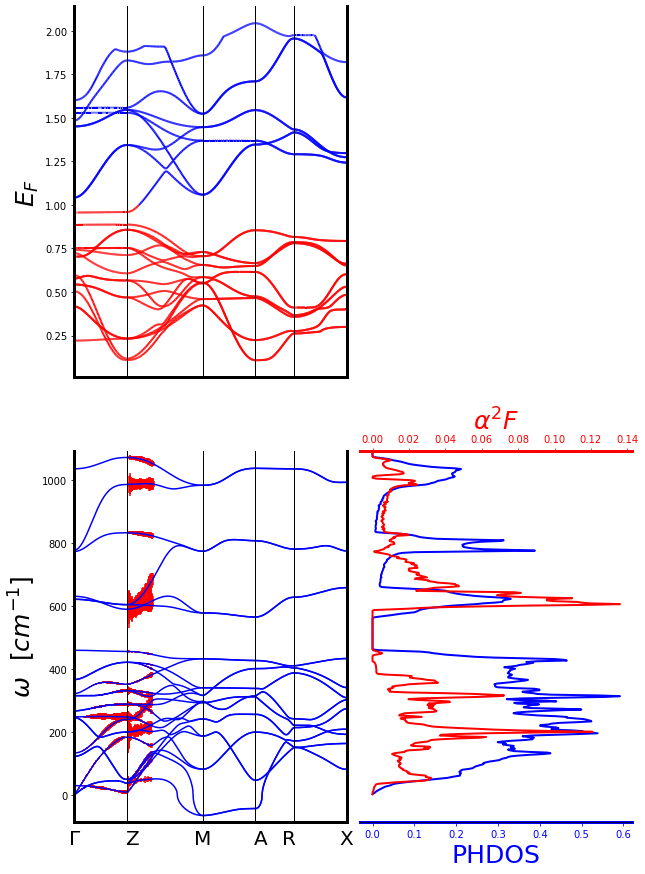

In [14]:
%matplotlib inline  
%config InlineBackend.figure_format = 'png'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

#name of the file containing the electron bands calculated by pw.x
pwx_file = 'P4nmm_e01_vc.bands.dat.gnu'

#name of the file containing the phonon dispersion calculated by ph.x
phx_file = 'P4nmm_e01_vc.freq.gp'

#name of the file containing the Wannier-interpolated phonon dispersion and linewidth calculated by epw.x
epwx_file = 'P4nmm_e01_vc.linewidth.phself_bands'

#name of phdos file
phdos_file = "P4nmm_e01_vc.phdos.01"

#name of a2F file
a2f_file = "P4nmm_e01_vc.a2f.01"

#indices of bands to plot
iband = np.array([30, 55])

#Fermi energy in eV
Ef = 8.6592

#define position of high symmetry k-points (need to be in cartesian coordinates)
hisym_points = ['G 0 0 0', 
                'Z 0 0.0 0.680411',
                'M 0.5 0.5 0.0',
                'A 0.5 0.5 0.680411',
                'R 0.0 0.5 0.680411',
                'X 0.0 0.5 0.0'
               ]

#define high symmetry lines path
hisym_path = ['G', 'Z', 'M', 'A', 'R', 'X']

#index for smearing column for phdos and a2F files (starting at 0)
smearing = 5

#____________________________________________________________________________________#
#____________________________________________________________________________________#


#___________________________________HISYM POINTS_____________________________________#
#get high symmetry point coordinates
qpoints = np.empty(shape=(len(hisym_path),3))
for ip, hisym_point in enumerate(hisym_path):
    for i in range(0, len(hisym_points)):
        hisym_point_comp = hisym_points[i].split(' ')[0]
        if hisym_point == hisym_point_comp:
            qpoints[ip] = [hisym_points[i].split(' ')[1], hisym_points[i].split(' ')[2], hisym_points[i].split(' ')[3]]

#transform to crystal coordinates
T = np.array([[1,0,0],[0,1,0],[0,0,7.749630000/5.177960000]])
qpoints_cryst = np.empty(shape=(len(hisym_path),3))
for i, qpoint in enumerate(qpoints):
    qpoints_cryst[i] = T.dot(qpoint)


hisym_dist = np.empty(0)
hisym_dist_cryst = np.empty(0)
for i in range(0, len(qpoints)-1):
    dist = np.linalg.norm(qpoints[i+1]-qpoints[i])
    hisym_dist = np.append(hisym_dist, dist)
    
    dist_cryst = np.linalg.norm(qpoints_cryst[i+1]-qpoints_cryst[i])
    hisym_dist_cryst = np.append(hisym_dist_cryst, dist_cryst)

hisym_loc = np.empty(0)
hisym_loc_cryst = np.empty(0)
for i in range(0, len(qpoints)):
    loc = 0
    loc_cryst = 0
    for j in range(0, i):
        loc += hisym_dist[j]
        loc_cryst += hisym_dist_cryst[j]
    hisym_loc = np.append(hisym_loc, loc)
    hisym_loc_cryst = np.append(hisym_loc_cryst, loc_cryst)

hisym_loc /= hisym_loc[len(hisym_loc)-1]
hisym_loc_cryst /= hisym_loc_cryst[len(hisym_loc_cryst)-1]

#___________________________________PREP DATA_____________________________________#
#read the electron bands from pwx_file
pwx_band_temp = open(pwx_file, 'r')
pwx_band_temp = pwx_band_temp.read()

nband = 0
nkpoint = 0
nk_temp = 0
for line in pwx_band_temp.split('\n'):
    if line == ' ':
        nband += 1
        if nband == 1:
            nkpoint = nk_temp
    else:
        nk_temp += 1        

pwx_band = np.empty(shape=(nkpoint,nband))

i=0
j=0
for line in pwx_band_temp.split('\n'):
    if line == ' ':
        j += 1
        if j == nband:
            break
        i = 0
        continue
    else:
        numbers = line.split(' ')
        numbers = list(filter(None, numbers))
        pwx_band[i, 0] = float(numbers[0])
        pwx_band[i, j] = float(numbers[1])
        i += 1
        

#resize the pwx_band k-axis and normalize to Ef
pwx_band[:,0] /= pwx_band[len(pwx_band[:,0])-1, 0]
pwx_band[:,1:] /= Ef

#read the phonon dispersion from phx_file 
phx_disp = np.loadtxt(phx_file)
nbranch = phx_disp.shape[1] - 1

#read the phonon dispersion and linewidths from epwx_file
epwx_disp_temp = np.loadtxt(epwx_file, skiprows=2, usecols=2)
epwx_phlw_temp = np.loadtxt(epwx_file, skiprows=2, usecols=3)
#reorder the data and convert data from meV to cm-1
nqpoint = int(epwx_disp_temp.shape[0] / nbranch)
epwx_disp = np.empty(shape=(nqpoint, nbranch))
epwx_phlw = np.empty(shape=(nqpoint, nbranch))
qpoint = 1
for i,freq in enumerate(epwx_disp_temp):
    branch = (i % nbranch) + 1
    if (branch == 1 and i != 0):
        qpoint += 1
    epwx_disp[qpoint-1,branch-1] = freq*8.06554
qpoint=1
for i,phlw in enumerate(epwx_phlw_temp):
    branch = (i % nbranch) + 1
    if (branch == 1 and i != 0):
        qpoint += 1
    epwx_phlw[qpoint-1,branch-1] = phlw*8.06554    
    
#resize the phx_disp q-axis
phx_disp[:,0] /= phx_disp[len(phx_disp[:,0])-1, 0]

#loading phdos and a2F data
phdos = np.loadtxt(phdos_file)
a2f = np.loadtxt(a2f_file)

#convert frequencies to cm-1
phdos[:,0] *= 8.06554
a2f[:,0] *= 8.06554

#___________________________________PLOT DATA_____________________________________#
wmin = np.amin(epwx_disp) - 20
wmax = np.amax(epwx_disp) + 20

plt.figure(1, figsize=[10,15])
ax = plt.subplot(2,2,1)

for i in range(iband[0], iband[1]):
    color_ = ['']*nkpoint
    for j, energy in enumerate(pwx_band[:,i]):
        if energy <= 1:
            color_[j] = 'red'
        else:
            color_[j] = 'blue'
            
    points = np.array([pwx_band[:,0], pwx_band[:,i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1) 
    lc = LineCollection(segments, colors=color_, linewidths=2)
    ax.add_collection(lc)
    ax.autoscale()

    ax.set_xlim((0,1))
    ax.set_ylabel("$E_{F}$", fontsize=25)
    ax.tick_params(axis='x', bottom=False, labelbottom=False, labelsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)

ax2 = plt.subplot(2,2,3)
for i in range(0, nbranch):
    #plot epwx dispersion
    ax2.plot(np.linspace(0,1,nqpoint), epwx_disp[:,i], color='blue')
    #plot phx dispersion
    #plt.plot(phx_disp[:,0], phx_disp[:,i], color='red', linestyle='-.')
    #plot the phonon linewidths
    ax2.scatter(np.linspace(0,1,nqpoint), epwx_disp[:,i], s=100*epwx_phlw[:,i], color='red', marker='|')
    
    ax2.set_xlim((0,1))
    ax2.set_ylim([wmin,wmax])
    ax2.set_ylabel("$\omega \ \ [cm^{-1}]$", fontsize=25)
    ax2.tick_params(axis='x', bottom=False, labelbottom=True, labelsize=20)
    labels=['$\Gamma$', 'Z', 'M', 'A', 'R', 'X']
    ax2.set_xticklabels(labels)
    ax2.set_xticks(hisym_loc_cryst)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_linewidth(3)
    ax2.spines['bottom'].set_linewidth(3)
    ax2.spines['right'].set_linewidth(3)

#plot high symmetry lines
for line in hisym_loc:
    ax.axvline(x=line,linewidth=1, color='k')
for line in hisym_loc:
    ax2.axvline(x=line,linewidth=1, color='k')


ax3 = plt.subplot(2,2,4)
ax3.plot(phdos[:,smearing], phdos[:,0], linewidth=2, color='b')

ax3.set_ylim([wmin,wmax])
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_linewidth(3)
ax3.spines['bottom'].set_color('b')
ax3.tick_params(axis='y', left=False, labelleft=False, labelsize=20, color='b')
ax3.tick_params(axis='x', colors='blue')
ax3.set_xlabel('PHDOS', fontsize=25, color='b')

ax4 = ax3.twiny()
ax4.plot(a2f[:,smearing], a2f[:,0], linewidth=2, color='r')

ax4.set_ylim([wmin,wmax])
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['top'].set_linewidth(3)
ax4.spines['top'].set_color('r')
ax4.tick_params(axis='y', left=False, labelleft=False, labelsize=20, color='r')
ax4.tick_params(axis='x', colors='red')
ax4.set_xlabel(r'$\alpha^2F$', fontsize=25, color='r')

plt.subplots_adjust(wspace=0.05)

plt.savefig('phlw.eps', bbox_inches='tight')  

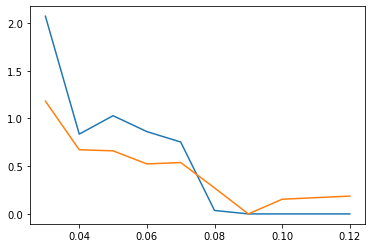

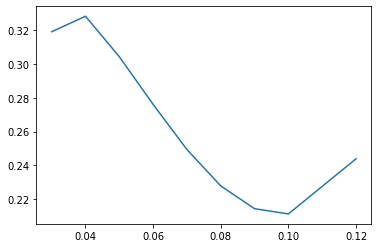

In [48]:
import numpy
import matplotlib.pyplot as plt

def calc_Tc(lambda_, logavg, l_a2F, mu):
    Tc = logavg / 1.2 * numpy.exp(-1.04*(1 + l_a2F) / (l_a2F - mu*(1 + 0.62 * l_a2F)))
    return Tc * 13.6056981 /  8.6173427909e-05

charge = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12] 
lambda_ = [1.1814840, 0.6719802, 0.6608159,  0.5235592, 0.5381315, 0.2727182, 0.000000, 0.1537388, 0.1868398]
logavg = [0.0001229, 0.0003265, 0.0002755, 0.0003251, 0.0003431, 0.0008156, 0.000000, 0.0016342, 0.0018095]
l_a2F = [1.4026651,0.5400392, 0.6067165, 0.5455088, 0.5176819, 0.2848448, 0.000000, 0.1537069, 0.1874695]
dos_f = [0.3192, 0.3284, 0.3044, 0.2761, 0.2493, 0.2277, 0.2142, 0.2111, 0.2438]

Tc = numpy.empty(0)
for i in range(0, len(lambda_)):
    Tc = numpy.append(Tc, calc_Tc(lambda_[i], logavg[i], l_a2F[i], 0.10))

plt.figure(1)
plt.plot(charge, Tc)
plt.plot(charge, lambda_)
plt.figure(2)
plt.plot(charge, dos_f)
plt.show()


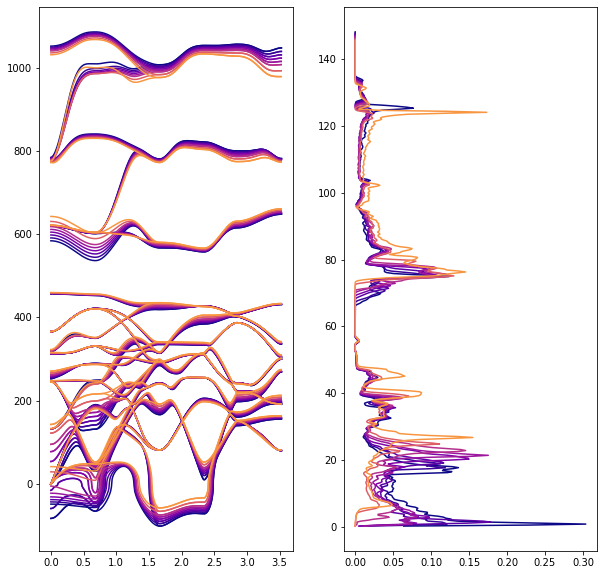

In [46]:
import numpy
import matplotlib.pyplot as plt

a2F_filenames = ["P4nmm_e003_vc/P4nmm_e003_vc.a2f.01",
                 "P4nmm_e004_vc/P4nmm_e004_vc.a2f.01",
                 "P4nmm_e005_vc/P4nmm_e005_vc.a2f.01",
                 "P4nmm_e006_vc/P4nmm_e006_vc.a2f.01",
                 "P4nmm_e007_vc/P4nmm_e007_vc.a2f.01",
                 "P4nmm_e008_vc/P4nmm_e008_vc.a2f.01",
                 "P4nmm_e01_vc/P4nmm_e01_vc.a2f.01",
                 "P4nmm_e012_vc/P4nmm_e012_vc.a2f.01"
                ]

ph_filenames = ["P4nmm_e003_vc/P4nmm_e003_vc.freq.gp",
                "P4nmm_e004_vc/P4nmm_e004_vc.freq.gp",
                "P4nmm_e005_vc/P4nmm_e005_vc.freq.gp",
                "P4nmm_e006_vc/P4nmm_e006_vc.freq.gp",
                "P4nmm_e007_vc/P4nmm_e007_vc.freq.gp",
                "P4nmm_e008_vc/P4nmm_e008_vc.freq.gp",
                "P4nmm_e01_vc/P4nmm_e01_vc.freq.gp",
                "P4nmm_e012_vc/P4nmm_e012_vc.freq.gp"
                ]

charges = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.12]

smearing = 7
nbranch = 25

a2F_files = []
ph_files = []

for file in a2F_filenames:
    a2F_files.append(numpy.loadtxt(file))


for file in ph_filenames:
    ph_files.append(numpy.loadtxt(file))

    
colormap = plt.cm.plasma
norm = plt.Normalize(vmin = charges[0], vmax=charges[len(charges)-1]*1.25)

plt.figure(1, figsize=[10,10])
    
ax = plt.subplot(1,2,1)

for i, file in enumerate(ph_files):
    for j in range(1, nbranch):
        ax.plot(file[:,0], file[:,j], color=colormap(norm(charges[i])))
        
ax2 = plt.subplot(1,2,2)

for i, file in enumerate(a2F_files):
    ax2.plot(file[:,smearing], file[:,0], color=colormap(norm(charges[i])))